In [121]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e2/sample_submission.csv
/kaggle/input/playground-series-s3e2/train.csv
/kaggle/input/playground-series-s3e2/test.csv
/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv


In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

#importing Classifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier

#F Score and other metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# Reading the datasets 

Original dataset from which the datasets given in the problem is derived from is also added.

In [123]:
# Read the train and test datasets

stroke_train = pd.read_csv("/kaggle/input/playground-series-s3e2/train.csv")
stroke_test = pd.read_csv("/kaggle/input/playground-series-s3e2/test.csv")

original_data = pd.read_csv("/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv")

# Exploring the datasets

In [124]:
stroke_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [125]:
original_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [126]:
stroke_test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


In [127]:
stroke_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [128]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [129]:
stroke_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 10204 non-null  int64  
 1   gender             10204 non-null  object 
 2   age                10204 non-null  float64
 3   hypertension       10204 non-null  int64  
 4   heart_disease      10204 non-null  int64  
 5   ever_married       10204 non-null  object 
 6   work_type          10204 non-null  object 
 7   Residence_type     10204 non-null  object 
 8   avg_glucose_level  10204 non-null  float64
 9   bmi                10204 non-null  float64
 10  smoking_status     10204 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 877.0+ KB


In [130]:
stroke_train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


In [131]:
original_data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [132]:
stroke_test.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000
mean,20405.500000,41.920713,0.051450,0.021756,89.197766,28.242351
std,2945.785407,21.097956,0.220925,0.145894,25.914364,6.733863
min,15304.000000,0.080000,0.000000,0.000000,55.120000,11.500000
25%,17854.750000,26.000000,0.000000,0.000000,75.060000,23.700000
50%,20405.500000,43.500000,0.000000,0.000000,85.070000,27.700000
75%,22956.250000,57.000000,0.000000,0.000000,96.750000,32.000000
max,25507.000000,82.000000,1.000000,1.000000,267.600000,97.600000


In [133]:
for column in stroke_train.columns:
    print(f"{column}:\n{stroke_train[column].value_counts()}\n")

id:
0        1
10207    1
10195    1
10196    1
10197    1
        ..
5105     1
5106     1
5107     1
5108     1
15303    1
Name: id, Length: 15304, dtype: int64

gender:
Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

age:
57.00    353
78.00    337
53.00    311
31.00    310
45.00    309
        ... 
0.16       6
0.08       6
0.48       3
1.30       2
0.68       1
Name: age, Length: 106, dtype: int64

hypertension:
0    14543
1      761
Name: hypertension, dtype: int64

heart_disease:
0    14947
1      357
Name: heart_disease, dtype: int64

ever_married:
Yes    10385
No      4919
Name: ever_married, dtype: int64

work_type:
Private          9752
children         2038
Self-employed    1939
Govt_job         1533
Never_worked       42
Name: work_type, dtype: int64

Residence_type:
Rural    7664
Urban    7640
Name: Residence_type, dtype: int64

avg_glucose_level:
93.88     33
85.84     33
77.55     32
72.49     31
73.00     31
          ..
229.92     1
61.12      

In [134]:
for column in stroke_test.columns:
    print(f"{column}:\n{original_data[column].value_counts()}\n")

id:
9046     1
22194    1
15104    1
28315    1
56996    1
        ..
897      1
4789     1
5686     1
37451    1
44679    1
Name: id, Length: 5110, dtype: int64

gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

age:
78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

hypertension:
0    4612
1     498
Name: hypertension, dtype: int64

heart_disease:
0    4834
1     276
Name: heart_disease, dtype: int64

ever_married:
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

avg_glucose_level:
93.88     6
91.68     5
91.85     5
83.16     5
73.00     5
         ..
111.93    1
94.40     1
95.57     1
6

In [135]:
for column in stroke_test.columns:
    print(f"{column}:\n{stroke_test[column].value_counts()}\n")

id:
15304    1
22110    1
22103    1
22104    1
22105    1
        ..
18705    1
18706    1
18707    1
18708    1
25507    1
Name: id, Length: 10204, dtype: int64

gender:
Female    6338
Male      3865
Other        1
Name: gender, dtype: int64

age:
57.00    243
78.00    243
45.00    220
52.00    215
31.00    210
        ... 
0.48       2
1.40       2
1.25       1
0.33       1
1.90       1
Name: age, Length: 106, dtype: int64

hypertension:
0    9679
1     525
Name: hypertension, dtype: int64

heart_disease:
0    9982
1     222
Name: heart_disease, dtype: int64

ever_married:
Yes    7073
No     3131
Name: ever_married, dtype: int64

work_type:
Private          6573
Self-employed    1349
children         1270
Govt_job          992
Never_worked       20
Name: work_type, dtype: int64

Residence_type:
Urban    5182
Rural    5022
Name: Residence_type, dtype: int64

avg_glucose_level:
93.88     27
90.42     26
83.16     23
86.06     22
91.85     22
          ..
108.52     1
112.27     1
70.3

In [136]:
# Correlation values for 'Stroke' column and other columns in training dataset

corr = stroke_train.corr()
print(corr['stroke'].sort_values(ascending=False))

stroke               1.000000
age                  0.261320
avg_glucose_level    0.149273
hypertension         0.145895
heart_disease        0.111518
bmi                  0.065393
id                  -0.017290
Name: stroke, dtype: float64


In [137]:
# Correlation values for 'Stroke' column and other columns in the original dataset

corr = original_data.corr()
print(corr['stroke'].sort_values(ascending=False))

stroke               1.000000
age                  0.245257
heart_disease        0.134914
avg_glucose_level    0.131945
hypertension         0.127904
bmi                  0.042374
id                   0.006388
Name: stroke, dtype: float64


In [138]:
nan_count = original_data[(original_data['stroke']==1) & (original_data['bmi'].isna())].shape[0]
print(nan_count)

40


In [139]:
nan_counts = original_data.isna().sum()
nan_counts

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [141]:
# Imputing the missing values in the dataset

imputer = SimpleImputer(strategy="median")
original_data['bmi'] = imputer.fit_transform(original_data[['bmi']])
original_data['bmi'].value_counts()

28.1    230
28.7     41
28.4     38
26.7     37
27.6     37
       ... 
48.7      1
49.2      1
51.0      1
49.4      1
14.9      1
Name: bmi, Length: 418, dtype: int64

# Visualising the dataset

<AxesSubplot:>

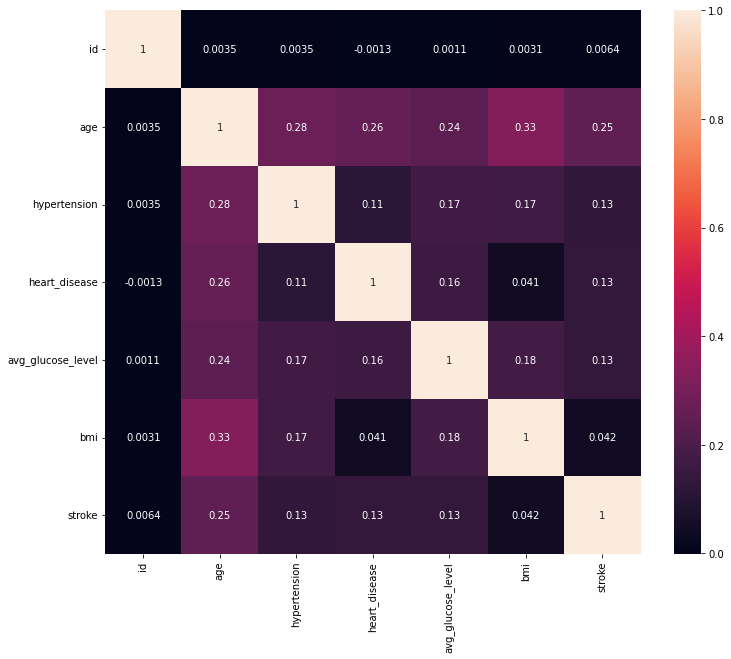

In [142]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot = True)

0    14672
1      632
Name: stroke, dtype: int64


<AxesSubplot:xlabel='stroke', ylabel='count'>

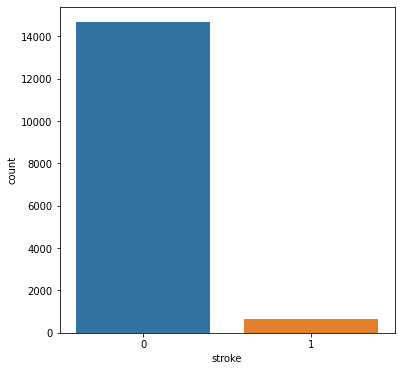

In [143]:
print(stroke_train['stroke'].value_counts())

plt.figure(figsize=(6,6))
sns.countplot(x='stroke', data=stroke_train)

<AxesSubplot:xlabel='age', ylabel='Density'>

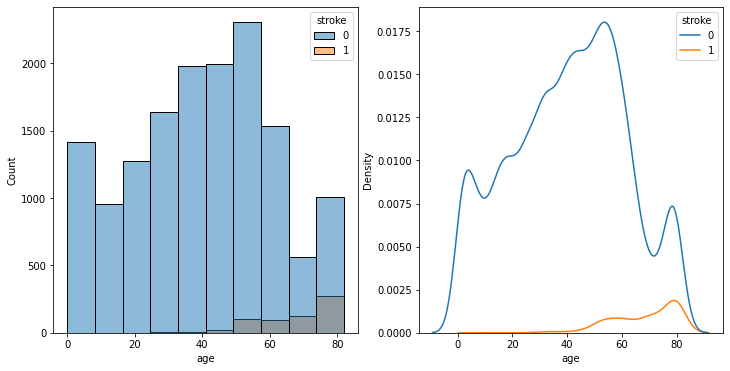

In [144]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.histplot(data=stroke_train, x='age', hue='stroke', ax=ax1, bins=10)
sns.kdeplot(data=stroke_train, x='age', hue='stroke', ax=ax2)

<AxesSubplot:xlabel='gender', ylabel='count'>

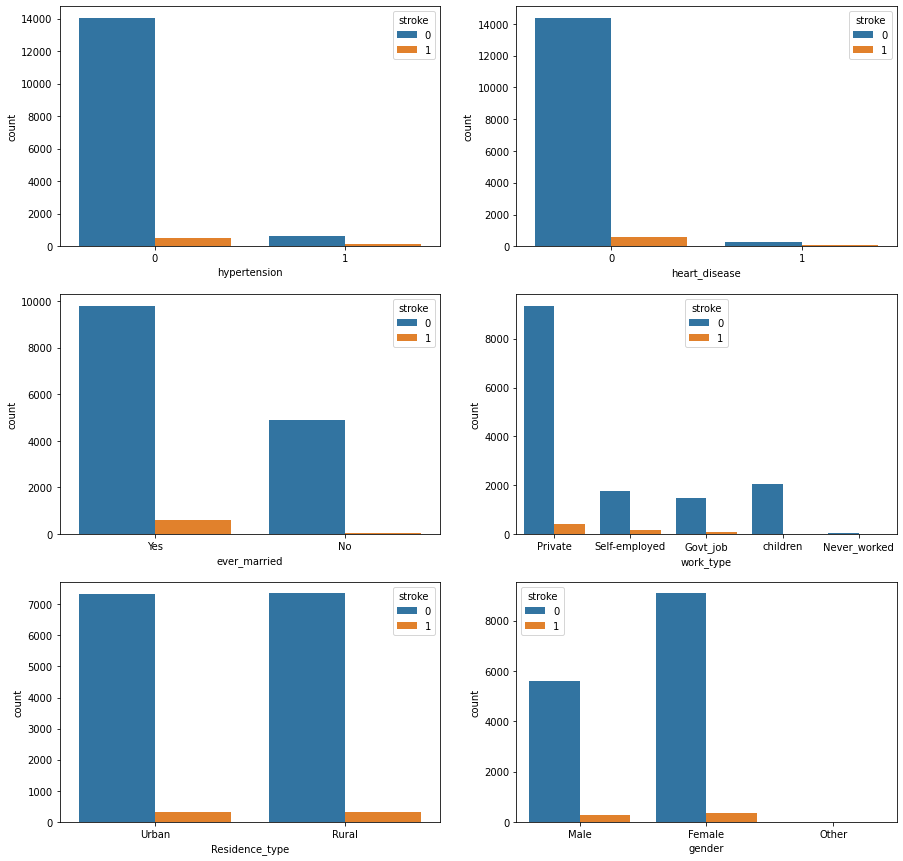

In [145]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))
sns.countplot(data=stroke_train, x='hypertension', hue='stroke', ax=ax[0,0])
sns.countplot(data=stroke_train, x='heart_disease', hue='stroke', ax=ax[0,1])
sns.countplot(data=stroke_train, x='ever_married', hue='stroke', ax=ax[1,0])
sns.countplot(data=stroke_train, x='work_type', hue='stroke', ax=ax[1,1])
sns.countplot(data=stroke_train, x='Residence_type', hue='stroke', ax=ax[2,0])
sns.countplot(data=stroke_train, x='gender', hue='stroke', ax=ax[2,1])

<AxesSubplot:xlabel='smoking_status', ylabel='count'>

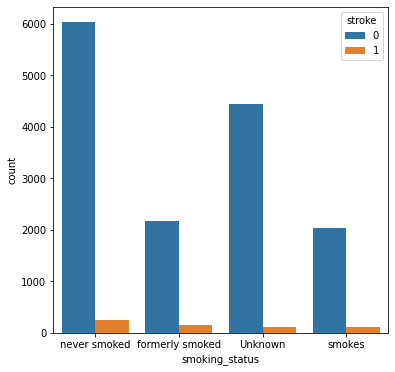

In [146]:
plt.figure(figsize=(6,6))
sns.countplot(data=stroke_train, x='smoking_status', hue='stroke')

<AxesSubplot:xlabel='bmi', ylabel='Density'>

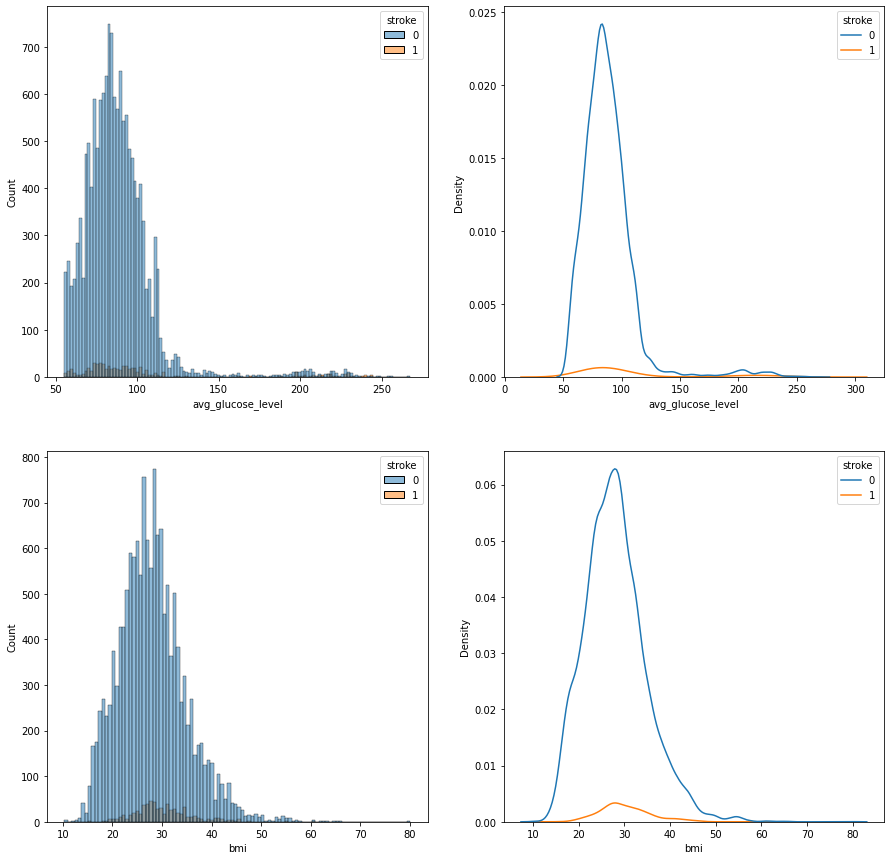

In [147]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
sns.histplot(data=stroke_train, x='avg_glucose_level', hue='stroke', ax=ax[0,0])
sns.kdeplot(data=stroke_train, x='avg_glucose_level', hue='stroke', ax=ax[0,1])
sns.histplot(data=stroke_train, x='bmi', hue='stroke', ax=ax[1,0])
sns.kdeplot(data=stroke_train, x='bmi', hue='stroke', ax=ax[1,1])

# Feature Transformation

In [148]:
# Encoding the categorical columns in the training dataset

Encode = LabelEncoder()
stroke_train['gender'] = Encode.fit_transform(stroke_train['gender'])
stroke_train['ever_married'] = Encode.fit_transform(stroke_train['ever_married'])
stroke_train['work_type'] = Encode.fit_transform(stroke_train['work_type'])
stroke_train['Residence_type'] = Encode.fit_transform(stroke_train['Residence_type'])
stroke_train['smoking_status'] = Encode.fit_transform(stroke_train['smoking_status'])
stroke_train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1,28.0,0,0,1,2,1,79.53,31.1,2,0
1,1,1,33.0,0,0,1,2,0,78.44,23.9,1,0
2,2,0,42.0,0,0,1,2,0,103.00,40.3,0,0
3,3,1,56.0,0,0,1,2,1,64.87,28.8,2,0
4,4,0,24.0,0,0,0,2,0,73.36,28.8,2,0


In [149]:
# Encoding the categorical columns in the test dataset

Encode = LabelEncoder()
stroke_test['gender'] = Encode.fit_transform(stroke_test['gender'])
stroke_test['ever_married'] = Encode.fit_transform(stroke_test['ever_married'])
stroke_test['work_type'] = Encode.fit_transform(stroke_test['work_type'])
stroke_test['Residence_type'] = Encode.fit_transform(stroke_test['Residence_type'])
stroke_test['smoking_status'] = Encode.fit_transform(stroke_test['smoking_status'])
stroke_test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,0,57.0,0,0,1,2,0,82.54,33.4,0
1,15305,1,70.0,1,0,1,2,1,72.06,28.5,0
2,15306,0,5.0,0,0,0,4,1,103.72,19.5,0
3,15307,0,56.0,0,0,1,0,1,69.24,41.4,3
4,15308,1,32.0,0,0,1,2,0,111.15,30.1,3


In [140]:
# Encoding the categorical columns in the original dataset

Encode = LabelEncoder()
original_data['gender'] = Encode.fit_transform(original_data['gender'])
original_data['ever_married'] = Encode.fit_transform(original_data['ever_married'])
original_data['work_type'] = Encode.fit_transform(original_data['work_type'])
original_data['Residence_type'] = Encode.fit_transform(original_data['Residence_type'])
original_data['smoking_status'] = Encode.fit_transform(original_data['smoking_status'])
original_data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1


# Selecting relevant features for traning and testing the model

In [151]:
# Selecting the desired columns for the model
X = stroke_train[['age','avg_glucose_level','hypertension', 'heart_disease', 'bmi', 'work_type', 'smoking_status']]
y = stroke_train['stroke']

# Split the dataset into a train and validation set
skf = StratifiedKFold(n_splits=10)

gbc = GradientBoostingClassifier()

# Fitting the model and evaluating result (Original data not added)

In [152]:
scores=[]

for train_index, val_index in skf.split(X, y):
    # Get the training and test data for this split
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y[train_index], y[val_index]
    
    # Fit the model on the training data
    gbc.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = gbc.predict(X_val)
    
      # Make predictions on the test data
    y_pred = gbc.predict_proba(X_val)[:, 1]
    
    # Calculate the accuracy score for this split    
    scores.append(roc_auc_score(y_val, y_pred))
   
print('The mean value for all the 10 folds is '+ str(np.mean(scores)))

The mean value for all the 10 folds is 0.8863754722504812


# Adding the original dataset to the train dataset

In [153]:
result_df = pd.concat([original_data, stroke_train], ignore_index=True)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20414 entries, 0 to 20413
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 20414 non-null  int64  
 1   gender             20414 non-null  int64  
 2   age                20414 non-null  float64
 3   hypertension       20414 non-null  int64  
 4   heart_disease      20414 non-null  int64  
 5   ever_married       20414 non-null  int64  
 6   work_type          20414 non-null  int64  
 7   Residence_type     20414 non-null  int64  
 8   avg_glucose_level  20414 non-null  float64
 9   bmi                20414 non-null  float64
 10  smoking_status     20414 non-null  int64  
 11  stroke             20414 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.9 MB


In [154]:
X2 = result_df[['age','avg_glucose_level','hypertension', 'heart_disease', 'bmi', 'work_type', 'smoking_status']]
y2 = result_df['stroke']

# Fitting the model and evaluating the result (original dataset added)

In [155]:
scores2=[]
gbc2 = GradientBoostingClassifier()
for train_index, val_index in skf.split(X2, y2):
    # Get the training and test data for this split
    X_train, X_val = X2.iloc[train_index], X2.iloc[val_index]
    y_train, y_val = y2[train_index], y2[val_index]
    
    # Fit the model on the training data
    gbc2.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = gbc2.predict(X_val)
    
     # Make predictions on the test data
    y_pred = gbc2.predict_proba(X_val)[:, 1]
    
    # Calculate the accuracy score for this split    
    scores2.append(roc_auc_score(y_val, y_pred))
   
print('The mean value for all the 10 folds is '+ str(np.mean(scores2))) 

The mean value for all the 10 folds is 0.8787588942335407


In [156]:
y_test = stroke_test[['age','avg_glucose_level','hypertension', 'heart_disease', 'bmi', 'work_type', 'smoking_status']]
y_test.head()

,age,avg_glucose_level,hypertension,heart_disease,bmi,work_type,smoking_status
0,57.0,82.54,0,0,33.4,2,0
1,70.0,72.06,1,0,28.5,2,0
2,5.0,103.72,0,0,19.5,4,0
3,56.0,69.24,0,0,41.4,0,3
4,32.0,111.15,0,0,30.1,2,3


In [157]:
# Make predictions on the test set
y_test_pred = gbc2.predict_proba(y_test)[:,1]

# Create a submission DataFrame
submission = pd.DataFrame({'id': stroke_test.id, 'stroke': y_test_pred})

# Save the submission DataFrame to a CSV file
submission.to_csv("stroke_submission.csv", index=False)

print("Your submission was successfully saved")

Your submission was successfully saved


I submitted the results for both fitting without original data and with original data. The Best scores I obtained are metioned below - 
                         

1. Without original data -  0.89641 (Private Score)      |   0.86512 (Public Score)
2. With original data          -  0.89897 (Private Score)      |   0.86982 (Public Score) 


Obtaining a better score from the current one is a possibility with Hyperparameter tuning.